<center>Master in Big Data Analytics</center>
<center>June 2023</center>
<h4><center>Master Thesis</center></h4>
<h2><center>Forecasting the electricity load daily peaks</center></h2>
<center>Jorge Guerra Rodríguez</center>

# Introduction

Regional load forecasting is predicting the load demand of an area for a certain time horizon in the future. It is one of the most important and classical issues in the literature and scientiﬁc community and is getting more and more important in recent years due to the electricity market deregulation.

The goal of this thesis is predicting the electricity load daily peaks. The solutions that have been given to this problem are as wide as one could imagine. Many authors have proposed different approaches for predicting the load daily peaks: from traditional methods for univariate historical data, such as auto-regressive integrated moving average models (ARIMA), to advanced machine learning methods with multivariate predictors like weather, calendar, and economics variables.

The estimated hour for the load daily peaks can be derived from forecasting the load and simply inspects the hour with the highest demand within each day. This thesis will follow the approach of forecasting the hourly electricity demand for finding the daily peaks within each day. The aim is making predictions using the Dynamic Factor Analysis model that takes into account weather covariates and reduces the dimension of the multivariate time series estimating some unobserved latent factors that are assumed to follow some ARIMA processes.



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib_inline.backend_inline import set_matplotlib_formats
style.use('seaborn-v0_8-whitegrid') or plt.style.use(['seaborn-v0_8-whitegrid'])
set_matplotlib_formats('svg')

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

fancy = ["#3B9AB2", "#78B7C5", "#EBCC2A", "#E1AF00", "#F21A00"]
fancy24 = ["#3B9AB2", "#459FB5", "#50A4B8", "#5AA9BB", "#65AEBF", 
           "#70B3C2", "#7DB7BE", "#91BBA3", "#A4BF88", "#B8C26D",
           "#CCC652", "#E1CA37", "#EAC926", "#E8C41F", "#E6BF17",
           "#E4BA10", "#E3B509", "#E1B001", "#E39B00", "#E68100",
           "#E96700", "#EC4D00", "#EF3300", "#F21A00"]
uc3m = '#27285C'

import warnings
warnings.filterwarnings('once')

The data consist in multiple time series with hourly frequency related to the electricity demand in megawatts (MW) in New England from January 1, 2017 to December 31, 2022. Being the goal of this thesis forecasting the electricity load daily peaks, the  hourly demand time series will be transformed into 24 daily time series. Each of the new series is the electricity demand for each hour in a day.

The series will be divided into a training and testing sets for training and evaluating the model performance, respectively. The former contains data from 2017 to 2020, while the later is data of the last two years 2021 and 2022.

In [2]:
data = pd.read_csv("/Users/jorge/Documents/BIG DATA ANALYTICS/MASTER THESIS/Bibliography/smd_data/Data.csv")
data['day'] = pd.to_datetime(data['day'])
data.set_index('day', inplace=True)
data = data.asfreq(freq ='D')
data = data.sort_index()

end_train  = '2021-01-01'
data_train = data.loc[: end_train, :].iloc[:-1]
data_test  = data.loc[end_train:, :]

print(f"Training set      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Testing set       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Training set      : 2017-01-01 00:00:00 --- 2020-12-31 00:00:00  (n=1461)
Testing set       : 2021-01-01 00:00:00 --- 2022-12-31 00:00:00  (n=730)


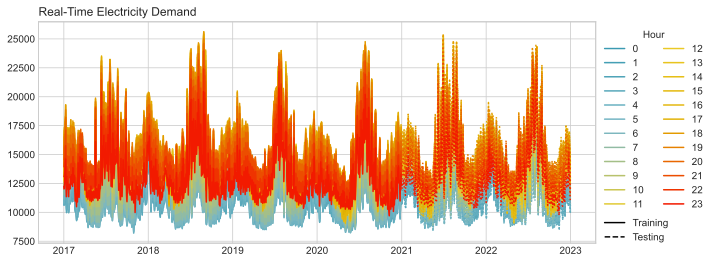

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(data_train.iloc[:,i], color = fancy24[i], label=i)
    ax.plot(data_test.iloc[:,i], color = fancy24[i], linestyle='dotted')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
ax.set_title("Real-Time Electricity Demand", loc="left")

ax2 = ax.twinx()
ax2.plot(np.NaN, np.NaN, linestyle='-', label='Training', c='k')
ax2.plot(np.NaN, np.NaN, linestyle='--', label='Testing', c='k')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.15))
plt.show()

We will consider some accuracy metrics to evaluate the goodness of fit of the predictions to the original data. Let $y_{h, d}$ be the electricity demand of day $d$ in the $h$-th hour, and $\widehat y_{h,d}$ its prediction. The relative prediction error of each hour and day is defined as $e_{h,d} = |y_{h, d} - \widehat y_{h, d}| / y_{h, d}$ and is used to define the daily accuracy metrics $\textrm{emean}_d = (1/24)\sum_{h = 1}^{24} e_{h,d}$ and $\textrm{emedian}_d = \textrm{median}(e_{1,d},\dots, e_{24,d})$ that are involved in the error metrics for a period of $D$ days:

\begin{equation}\label{eq:mape}
    \textrm{MAPE} = \frac{1}{D} \sum_{d = 1}^D \textrm{emean}_d,
\end{equation}

\begin{equation}\label{eq:mdape}
    \textrm{MDAPE} = \frac{1}{D} \sum_{d = 1}^D \textrm{emedian}_d.
\end{equation}

We will also measure the accuracy of the peaks forecasting as the hit ratio of the number of predicted peaks that take place in the actual peaks of each day to $D$. Let $p_d$ be the hour in which the load peak of day $d$ happens and $\widehat p_d$ its predicted value. Then the accuracy for a period of $D$ days:

\begin{equation}\label{eq:accuracy}
    \textrm{Accuracy} = \frac{1}{D} \sum_{d = 1}^D \mathbb{I}\left(p_d, \, \widehat p_d \right),
\end{equation}
where 

\begin{equation}
    \mathbb{I}\left(p_d, \, \widehat p_d \right) = 
    \begin{cases}
    1 & \mathrm{if} \; p_d = \widehat p_d,\\
    0 & \mathrm{otherwise}
    \end{cases}.
\end{equation} 

While it is crucial to assess the hit ratio of the predicted peaks, it is important to acknowledge that this problem involves multinomial classification with many categories. Consequently, some errors in classification are anticipated, which may compromise the overall accuracy. Deviating by an hour when predicting the daily load peak is less significant compared to errors of several hours. To assess how much the predicted time deviates from the actual peak time, we propose introducing the mean absolute error for a period of $D$ days:
\begin{equation}\label{eq:mae}
    \mathrm{MAE} = \frac{1}{D} \sum_{d=1}^D |p_d - \widehat p_d|.
\end{equation}

In [4]:
def mape(Y, PredY):
    e        = np.abs(Y-PredY)/Y
    emeand   = e.apply(np.mean, axis=1)
    emediand = e.apply(np.median, axis=1)
    return {"MAPE": np.mean(emeand), "MDAPE": np.mean(emediand)}

def accuracy(Y, PredY):
    Peak = Y.apply(np.argmax, axis=1)
    PredPeak = PredY.apply(np.argmax, axis=1)
    return np.mean(Peak == PredPeak)

def mae(Y, PredY):
    Peak = Y.apply(np.argmax, axis=1)
    PredPeak = PredY.apply(np.argmax, axis=1)
    return np.mean(np.abs(PredPeak - Peak))

# Dummy Model

A dummy model is a classifier that makes predictions ignoring the input features and following an specific strategy. It is a simple baseline model that serves as a reference point for comparison with more complex models. They are basic and straightforward models that typically relies on naïve assumptions and are intentionally designed to be simplistic.

Comparing the performance of an advanced model to the dummy model is useful to assess the effectiveness of the former. If a complex model performs only slightly better than the dummy model, it may indicate that the additional complexity is not justified or that there is room for improvement.

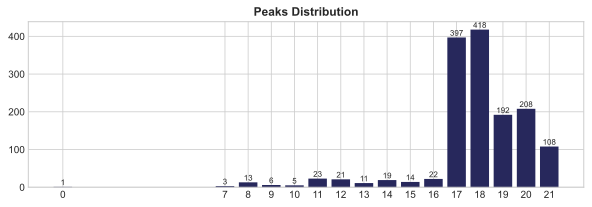

In [5]:
peaks = data_train.iloc[:, :24].apply(np.argmax, axis=1).value_counts(sort=False)

fig, axs = plt.subplots(figsize=(10, 3))
axs.bar(peaks.index, peaks, color=uc3m)
axs.set_xticks(peaks.index)
axs.set_title("Peaks Distribution", fontweight="bold")
for i, peak in enumerate(peaks):
    axs.text(peaks.index[i], peak + 0.5, str(peak), ha='center', va='bottom', fontsize=8)
plt.show()

It has been said that forecasting the electricity load daily peaks can be understood as a classification problem. Hence, we will measure the accuracy and MAE of a dummy classifier for further comparisons. We observe that that the majority of days in the training set have their load peak occurring at 18:00. Using a dummy model that assumes the load peaks occur at 18:00 for every day, the resulting accuracy is 0.30 and a mean absolute error of 1.25. This is our benchmark to assess the effectiveness of the approaches given in this thesis.

In [6]:
Peak = data_test.iloc[:, :24].apply(np.argmax, axis=1)
PredPeak = np.repeat(18, len(Peak))
print(f'Accuracy: {np.mean(Peak == PredPeak)} \nPeaks MAE: {np.mean(np.abs(PredPeak - Peak))}')

Accuracy: 0.3013698630136986 
Peaks MAE: 1.247945205479452


# Dynamic Factor Model

Let $\{\pmb y_t = (y_{1t}, \dots, y_{kt})',\; 1\leq t \leq T \}$ be a realization of a  $k$ dimensional stationary time series. Assume that each time series has been demeaned or centered by subtracting each sample mean and denote $\pmb Y$ the $T\times k$ data matrix whose $t$-th row is $\pmb y'_t$.


The Dynamic Factor Model (DFM) assumes that a vector time series, $\pmb y_t$, can be written in terms of $r < k$ unobserved common factors $\pmb f_t$:

\begin{equation}
    \pmb y_t = \pmb P \pmb f_t + \pmb \eta_t,
\end{equation}
where $\pmb f_t = (f_{1t}, \dots, f_{rt})'$ is the vector of common factors, $\pmb P$ is the matrix of loadings and $\pmb \eta_t = (\eta_{1t}, \dots, \eta_{kt})$ is the idiosyncratic series. In addition to the structural equation, we need to specify which model do the latent factors follow in further sections.


The latent factors can be estimated via PCA. In our training set, after standardizing the training set and performing the PCA over it, we discovered that considering three principal components is enough for them to explain the $97\%$ of the information.

Furthermore, applying the Yeo-Johnson power transformationto the latent factors will aid in meeting the assumptions of the later models to be introduced. 

\begin{equation}\label{eq:yeojohnson}
    f_i^{(\lambda)} = \begin{cases}
        \{(f_{i}+1)^\lambda-1\}/\lambda, & \lambda \not = 0, \, f_{i} \geq 0, \\
        \log(f_{i}+1), & \lambda = 0, \, f_{i} \geq 0,\\
        -\{(-f_{i}+1)^{(2-\lambda)}-1\}/(2-\lambda), & \lambda \not = 2, \, f_{i} < 0,\\
        -\log(-f_{i}+1), & \lambda = 2, \, f_{i} < 0.
    \end{cases}
\end{equation}

The parameters of the transformation are estimated maximizing the likelihood over the training set and next we apply the transformation to both partitions. The graph in plot exhibits the transformed latent factors that will be used for training and evaluating the forecasting procedures.

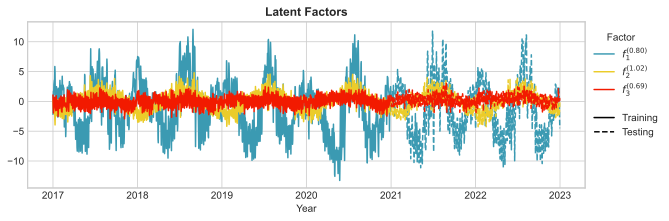

Proportion of explained variance: 97.06%


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer

# Define the model
pca_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=3)),
    ('PowerTransform', PowerTransformer(method='yeo-johnson', standardize=False))
])

# Fit the model
pca_pipe.fit(data_train.iloc[:, 0:24])
pca_model    = pca_pipe.named_steps['PCA']
scaler       = pca_pipe.named_steps['Scaler']
yj_transform = pca_pipe.named_steps['PowerTransform']
lambdas = yj_transform.lambdas_

# Estimate the latent factors
pcs_train = pca_pipe.transform(X=data_train.iloc[:, 0:24])
pcs_test = pca_pipe.transform(X=data_test.iloc[:, 0:24])

pcs_train = pd.DataFrame(
    pcs_train,
    columns = ['PC1', 'PC2', 'PC3'],
    index   = data_train.index
)

pcs_test  = pd.DataFrame(
    pcs_test,
    columns = ['PC1', 'PC2', 'PC3'],
    index   = data_test.index
)

# Plot the latent factors
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(pcs_train.PC1, c=fancy[0], label='$f_1^{(%.2f)}$' % lambdas[0])
ax.plot(pcs_train.PC2, c=fancy[2], label='$f_2^{(%.2f)}$' % lambdas[1])
ax.plot(pcs_train.PC3, c=fancy[4], label='$f_3^{(%.2f)}$' % lambdas[2])

ax.plot(pcs_test.PC1, c=fancy[0], linestyle='--')
ax.plot(pcs_test.PC2, c=fancy[2], linestyle='--')
ax.plot(pcs_test.PC3, c=fancy[4], linestyle='--')

ax.set_xlabel('Year')
ax.set_title('Latent Factors', fontweight='bold')
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5), title='Factor')

ax2 = ax.twinx()
ax2.plot(np.NaN, np.NaN, linestyle='-', label='Training', c='k')
ax2.plot(np.NaN, np.NaN, linestyle='--', label='Testing', c='k')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

print("Proportion of explained variance: {:.2f}%".format(sum(pca_model.explained_variance_ratio_)*100))

One can measure the influence of each original time series in each principal component.

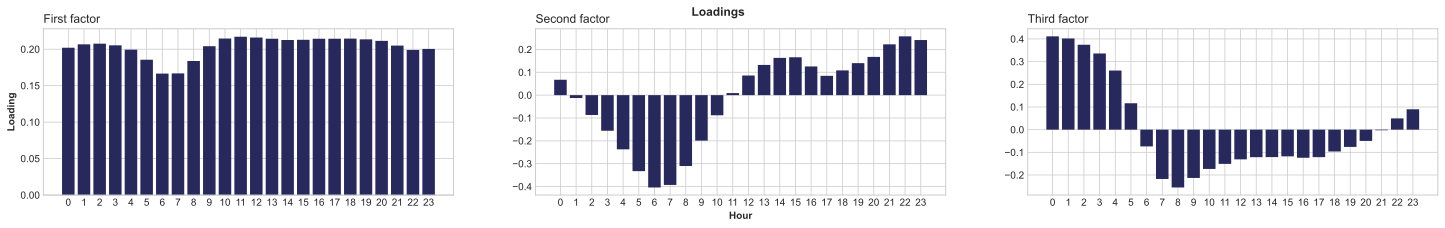

In [8]:
# Plot the loadings
loadings = pd.DataFrame(
    pca_model.components_.T,
    columns = ['PC1', 'PC2', 'PC3']
)

loadings['var'] = [str(x) for x in range(0,24)]

fig, axes = plt.subplots(1, 3, figsize=(25, 3))
axes[0].bar(loadings['var'], loadings['PC1'], color = uc3m)
axes[0].set_title('First factor', loc='left')
axes[0].set_ylabel('Loading', fontweight='bold')
axes[1].bar(loadings['var'], loadings['PC2'], color = uc3m)
axes[1].set_title('Second factor', loc='left')
axes[1].set_xlabel('Hour', fontweight='bold')
axes[2].bar(loadings['var'], loadings['PC3'], color = uc3m)
axes[2].set_title('Third factor', loc='left')

fig.suptitle('Loadings', fontweight='bold')
plt.show()

## Reconstruction of the Testing Set

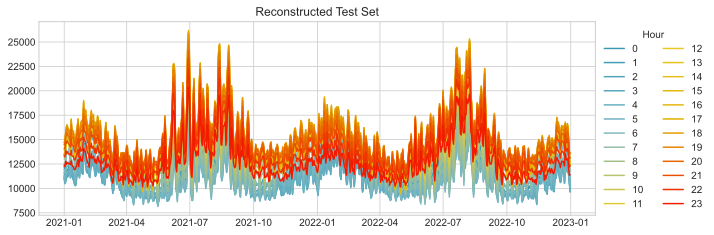

In [9]:
PredY = pca_pipe.inverse_transform(pcs_test.to_numpy())
PredY = pd.DataFrame(PredY, 
                     columns = data_test.iloc[:, 0:24].columns, 
                     index   = data_test.index)



fig, ax = plt.subplots(figsize=(10, 3.5))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
ax.set_title("Reconstructed Test Set")
plt.show()

There are some limitations to this study though. It was discovered that the purposed models estimates latent factors that could only achieve a certain limited maximum accuracy. Indeed, if we consider the three estimated factors from the test set as if they were the predictions, which would be the best possible prediction, and then transform these factors back to the original space, we achieve a maximum accuracy of 0.41.

In [10]:
metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

MAPE     = 0.021991317885389976 
MDAPE    = 0.01979526238246898
Accuracy = 0.4123287671232877
MAE      = 1.021917808219178


This insight yields that although three principal components are sufficient to explain 97\% of the variance, this information does not entirely capture the fluctuations in the data. Consequently, due to the similarity of electricity demands in consecutive hours, even a small variation in the series could result in a poor prediction of peaks, despite obtaining a small mean absolute percentage error.

## Estimating the ARIMA models

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from skforecast.ForecasterSarimax import ForecasterSarimax
from pmdarima import ARIMA
from skforecast.model_selection_sarimax import backtesting_sarimax

We need to allow each factor $f_{i,t}$ for $1 \leq i \leq r$ to follow a multiplicative seasonal Auto-Regressive Integrated Moving Average $\mathrm{ARIMA}(p,d,q)\times (P,D,Q)_s$ model:
\begin{equation}\label{eq:SARIMA}
    \Phi(B^s) \phi(B) \nabla_s^D \nabla^d f_{i,t} =  \theta(B) \Theta(B^s) \varepsilon_t,
\end{equation}
where 

- $\Phi(B^s) = 1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps}$, 
- $\phi(B) = 1 - \phi_1 B - \phi_2 B^2 - \cdots - \phi_p B^p$,
- $\theta(B) = 1 - \theta_1 B - \theta_2 B^2 - \cdots - \theta_q B^q$, 
- $\Theta(B^s) = 1 - \Theta_1 B^s - \Theta_2 B^{2s} - \cdots - \Theta_Q B^{Qs}$,

$B$ is the backshift operator such that $B f_{i,t} = f_{i,t-1}$, $\nabla$ is the difference operator such that $\nabla f_{i,t} = (1-B)f_{i,t}$, $\nabla_s$ is the seasonal difference operator such that $\nabla_s f_{i,t} = (1-B^s)f_{i,t}$, the roots of $|\phi(B)| = 0$, $|\Phi(B^s)| = 0$, $|\theta(B)| = 0$ and $|\Theta(B^s)| = 0$ lie outside the unit circle, and $\varepsilon_t$ is a standard Gaussian serially uncorrelated random variable. 


We need to select the orders of the models that best fit the latent factors. Instead of deciding the value of the ARIMA orders by choice inspecting the auto-correlation and partial auto-correlation plots, we will perform a grid search for choosing the model with lowest Akaike Information Criterion (AIC) and check that the assumptions are fulfilled. 

The following code blocks are responsible for selecting the orders of each ARIMA process by minimizing the AIC. However, they have been commented out because they take a significant amount of time to execute.

## Forecasting

We will explore different forecasting scenarios to evaluate the models, aiming for each of them to be more favorable and reflective of reality than its previous one, leading to give a better performance.


- **Scenario 1.**  Backtesting the models with a one-month forecast horizon. The models will be retrained in each of the $25$ time windows, spanning 30 days each, over the 730 days that the training set has. 
- **Scenario 2.** The models will be backtested with a one-week forecast horizon. Having 105 time windows, with each window covering a span of 7 days, makes it computationally expensive to retrain all the models. Hence, we will not retrain these models.
- **Scenario 3.** Similar to Scenario 2, this scenario involves backtesting the models, but with a one-day forecast horizon. Retraining the 730 models for each factor would be even more computationally expensive. Thus, the models will not be retrained.

In [12]:
pcs = pd.concat([pcs_train, pcs_test])

forecaster_arimaf1 = ForecasterSarimax(regressor = ARIMA(order=(4,1,2), seasonal_order = (1,0,1,7),
                                                        suppress_warnings=True))
forecaster_arimaf2 = ForecasterSarimax(regressor = ARIMA(order=(2,0,1), seasonal_order = (1,0,1,7),
                                                        suppress_warnings=True))
forecaster_arimaf3 = ForecasterSarimax(regressor = ARIMA(order=(1,1,1), seasonal_order = (1,0,1,7),
                                                        suppress_warnings=True))

### Scenario 1

In [13]:
metrica, f1s1 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf1,
                            y                  = pcs.PC1,
                            initial_train_size = len(pcs_train),
                            steps              = 30,
                            metric             = 'mean_absolute_error',
                            refit              = True,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f2s1 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf2,
                            y                  = pcs.PC2,
                            initial_train_size = len(pcs_train),
                            steps              = 30,
                            metric             = 'mean_absolute_error',
                            refit              = True,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f3s1 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf3,
                            y                  = pcs.PC3,
                            initial_train_size = len(pcs_train),
                            steps              = 30,
                            metric             = 'mean_absolute_error',
                            refit              = True,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

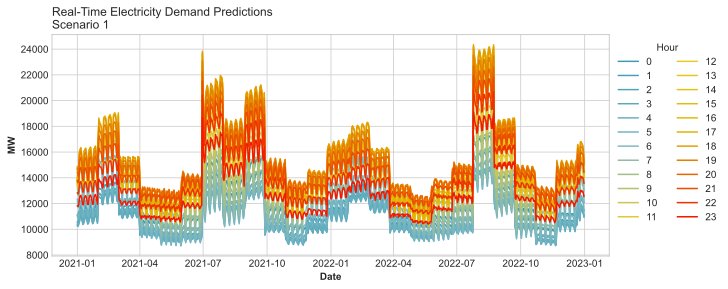

MAPE     = 0.10534590231707461 
MDAPE    = 0.10282810488282773
Accuracy = 0.29726027397260274
MAE      = 1.2356164383561643


In [14]:
PredF = pd.DataFrame({  # this is the forecasting scaled with YJ
    "PC1": f1s1["pred"],
    "PC2": f2s1["pred"],
    "PC3": f3s1["pred"]},
    index   = data_test.index)

PredY = pca_pipe.inverse_transform(PredF.to_numpy()) # Express the forecasting in their original space

PredY = pd.DataFrame(
    PredY,
    columns = data_train.iloc[:, 0:24].columns,
    index   = data_test.index)

# Plot the forecasting
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.set_title("Real-Time Electricity Demand Predictions \nScenario 1", loc="left")
ax.set_xlabel("Date", fontweight="bold")
ax.set_ylabel("MW", fontweight="bold")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

The evaluation metrics shows that although the models may exhibit room for improvement in terms of accuracy predicting the peaks, the predictions of the electricity demand present low goodness of fit metrics. This situation can be attributed to the fact that although the predictions of the demand are generally accurate, the model fail in capturing subtle variations in the data occurring in contiguous hours, which are crucial for accurately predicting peak values.

To face this issue we purpose a solution that involves calculating the Euclidean distance between each prediction point and the electricity demand of all the days in the training set. By doing so, we can identify the peak hour from the nearest training set day and assign it as the predicted peak. Moreover, considering the fact that the majority of peaks occur between 17:00 and 19:00 we can introduce a weighted Euclidean distance that assigns greater importance to the proximity during those hours.

In [15]:
T = PredY.shape[0]
k = PredY.shape[1]

x = data_test.iloc[:, 0:24].values
y = PredY.values

q = x[:, np.newaxis] - y
w = np.where((np.arange(24) >= 17) & (np.arange(24) <= 19), 2, 1)
distances = np.sqrt(np.sum(w * q**2, axis=2))

nearest_indices = np.argmin(distances, axis=1)
smooth_PredY    = data_train.iloc[nearest_indices, 0:24]
smooth_PredY    = smooth_PredY.set_index(data_test.index)

summary = f"Accuracy = {accuracy(data_test.iloc[:, 0:24], smooth_PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], smooth_PredY)}"
print(summary)

Accuracy = 0.32602739726027397
MAE      = 1.9109589041095891


Based on the idea presented in the last paragraphs we trained a K-nearest neighbors (KNN) model using the electricity demand data from training days along with their respective peak hours. This approach was expected to show an improved performance compared to the previous method as, after a hyper-parameter tuning that maximizes the accuracy, it considers eleven days rather than relying solely on the most similar day. The KNN classification is computed from a simple majority vote of the eleven nearest neighbors,  in terms of Euclidean distance, of each day. A query day will be assigned to the peak hour which has the most representatives within the nearest neighbors of that day.

The methodology involves using the KNN model to predict the peak hours based on the electricity demand predictions made by the DFM, which is the model that best performed. This is leaving aside the classical approach of forecasting the demand and simply inspecting the the hour with the highest demand within each day aimed to boost the performance.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

X_train = data_train.iloc[:, 0:24]
y_train = X_train.apply(np.argmax, axis=1)

# Classes with a small amount of instances
indices_to_delete = np.where((y_train != 17) & (y_train != 18) & 
                             (y_train != 19) & (y_train != 20) &
                             (y_train != 21))

# Delete the corresponding elements from X_train and y_train
X_train = np.delete(X_train, indices_to_delete, axis=0)
y_train = np.delete(y_train, indices_to_delete)

parameters = {"n_neighbors": range(1, 30, 5),
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": range(10, 40, 10),
             "metric": ["euclidean"]}

estimator  = KNeighborsClassifier()

KNN = GridSearchCV(estimator=estimator,
                   param_grid=parameters,
                   scoring = 'accuracy',
                   n_jobs = -1,
                   cv = 5)

KNN.fit(X=X_train, y=y_train)

def KNNaccuracy(Y, PredY):
    PredPeak = KNN.predict(X=Y.to_numpy())
    Peak = Y.apply(np.argmax, axis=1)
    print("Accuracy = ", np.mean(PredPeak == Peak))
    print("MAE      = ", np.mean(np.abs(PredPeak - Peak)))
    

print("\nKNN:")
KNNaccuracy(data_test.iloc[:, 0:24], PredY)


KNN:
Accuracy =  0.6410958904109589
MAE      =  0.773972602739726


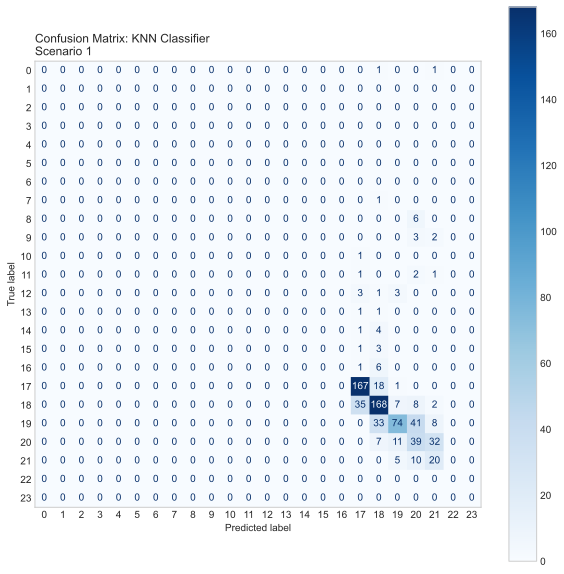

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Y = data_test.iloc[:, 0:24]
Peak = Y.apply(np.argmax, axis=1)
PredPeak = KNN.predict(X=Y.to_numpy())

m = confusion_matrix(Peak, PredPeak, labels=[i for i in range(24)])
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Blues  # Change color map here
disp = ConfusionMatrixDisplay(confusion_matrix=m, display_labels=[i for i in range(24)])
disp.plot(ax=ax, cmap=cmap)
ax.grid(False)
ax.set_title("Confusion Matrix: KNN Classifier \nScenario 1", loc="left")
plt.show()

### Scenario 2

In [18]:
metrica, f1s2 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf1,
                            y                  = pcs.PC1,
                            initial_train_size = len(pcs_train),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f2s2 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf2,
                            y                  = pcs.PC2,
                            initial_train_size = len(pcs_train),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f3s2 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf3,
                            y                  = pcs.PC3,
                            initial_train_size = len(pcs_train),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

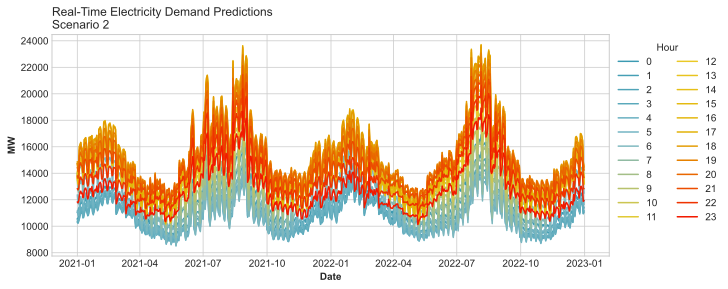

MAPE     = 0.07597718967190821 
MDAPE    = 0.07289845039152139
Accuracy = 0.38904109589041097
MAE      = 1.1164383561643836

KNN:
Accuracy =  0.6410958904109589
MAE      =  0.773972602739726


In [19]:
PredF = pd.DataFrame({  # this is the forecasting scaled with YJ
    "PC1": f1s2["pred"],
    "PC2": f2s2["pred"],
    "PC3": f3s2["pred"]},
    index   = data_test.index)

PredY = pca_pipe.inverse_transform(PredF.to_numpy())

PredY = pd.DataFrame(
    PredY,
    columns = data_train.iloc[:, 0:24].columns,
    index   = data_test.index
)

fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.set_title("Real-Time Electricity Demand Predictions \nScenario 2", loc="left")
ax.set_xlabel("Date", fontweight="bold")
ax.set_ylabel("MW", fontweight="bold")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

print("\nKNN:")
KNNaccuracy(data_test.iloc[:, 0:24], PredY)

### Scenario 3

In [20]:
metrica, f1s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf1,
                            y                  = pcs.PC1,
                            initial_train_size = len(pcs_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f2s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf2,
                            y                  = pcs.PC2,
                            initial_train_size = len(pcs_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f3s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf3,
                            y                  = pcs.PC3,
                            initial_train_size = len(pcs_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

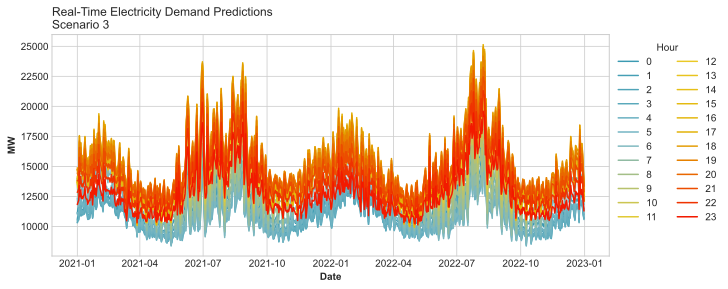

MAPE     = 0.05440271002751238 
MDAPE    = 0.05059358212615269
Accuracy = 0.4054794520547945
MAE      = 1.093150684931507

KNN:
Accuracy =  0.6410958904109589
MAE      =  0.773972602739726


In [21]:
PredF = pd.DataFrame({  # this is the forecasting scaled with YJ
    "PC1": f1s3["pred"],
    "PC2": f2s3["pred"],
    "PC3": f3s3["pred"]},
    index   = data_test.index)

PredY = pca_pipe.inverse_transform(PredF.to_numpy())

PredY = pd.DataFrame(
    PredY,
    columns = data_train.iloc[:, 0:24].columns,
    index   = data_test.index
)

fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.set_title("Real-Time Electricity Demand Predictions \nScenario 3", loc="left")
ax.set_xlabel("Date", fontweight="bold")
ax.set_ylabel("MW", fontweight="bold")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

print("\nKNN:")
KNNaccuracy(data_test.iloc[:, 0:24], PredY)

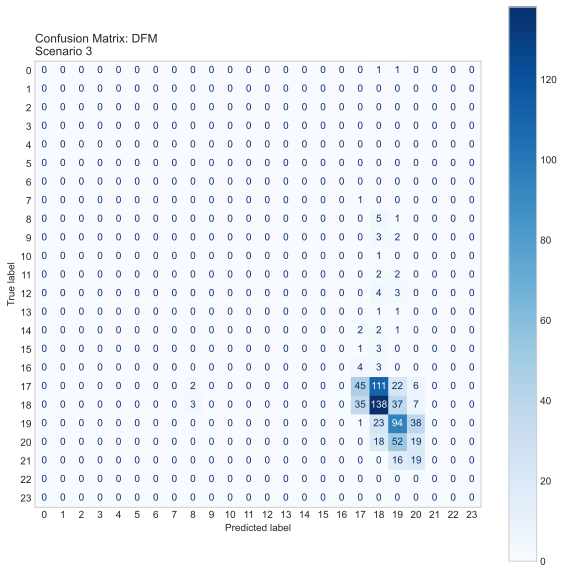

In [22]:
Y = data_test.iloc[:, 0:24]
Peak = Y.apply(np.argmax, axis=1)
PredPeak = PredY.apply(np.argmax, axis=1)
m = confusion_matrix(Peak, PredPeak, labels=[i for i in range(24)])
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Blues  # Change color map here
disp = ConfusionMatrixDisplay(confusion_matrix=m, display_labels=[i for i in range(24)])
disp.plot(ax=ax, cmap=cmap)
ax.grid(False)
ax.set_title("Confusion Matrix: DFM \nScenario 3", loc="left")
plt.show()

# Interactive Fixed-effects Model

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

The approach given in the last section  does not take into account the temperature exogenous variables as regressors that are expected to be correlated with the electricity demand. For $\{\pmb y_t = (y_{1t}, \dots, y_{kt})',\; 1\leq t \leq T \}$ being a realization of a  $k$ dimensional time series, we will consider the interactive fixed-effects model (IFEM):
\begin{equation}\label{eq:IFE1}
    y_{it} = \pmb x'_{it} \pmb \beta_i + \pmb \lambda'_i \pmb f_t + \eta_{it},
\end{equation}
for $i = 1, \dots, k$, and $\pmb x_{it}$ is a $p\times 1$ vector of $p$ observable regressors, $\pmb \beta_i$ is a $p\times 1$ vector of unknown coefficients, $\pmb \lambda_i$ $(r \times 1)$ are the factor loadings, $\pmb f_t$ $(r \times 1)$ a vector of unobserved common factors and $\eta_{it}$ is the $i$-th idiosyncratic noise.

The  interactive fixed-effects model can be also written for each time series $i = 1, \dots, k$ as: 
\begin{equation}\label{eq:IFE2}
    \pmb y_i = \pmb X_i \pmb \beta_i + \pmb F \pmb \lambda_i + \pmb \eta_i,
\end{equation}
where 
\begin{equation*}
\begin{array}{ccccc}
\pmb y_i = 
\begin{bmatrix} y_{i1} \\ y_{i2} \\ \vdots \\ y_{iT}\end{bmatrix}, & 
\pmb X_i = 
\begin{bmatrix} \pmb x'_{i1} \\ \pmb x'_{i2} \\ \vdots \\ \pmb x'_{iT}\end{bmatrix}, &
\pmb F = 
\begin{bmatrix} \pmb f'_{1} \\ \pmb f'_{2} \\ \vdots \\ \pmb f'_{T}\end{bmatrix} & 
\mathrm{and} &
\pmb \eta_i = 
\begin{bmatrix} \eta_{i1} \\ \eta_{i2} \\ \vdots \\ \eta_{iT}\end{bmatrix}.
\end{array}
\end{equation*}

The estimation of the IFEM requires a numerical method that was implemented for this thesis. Let $\pmb \beta = \{\pmb \beta_1, \dots, \pmb \beta_k \}$ be the vector of regression coefficients, and  $\pmb F$ and $\pmb P$  be the matrices of common factors and loadings, respectively. We will estimate the model numerically minimizing the sum of squared residual loss function:
\begin{equation}
    \mathrm{SSR}(\pmb \beta,\, \pmb F,\, \pmb P) = 
    \sum_{i=1}^k \sum_{t=1}^T (y_{it} - \pmb x'_{it} \pmb \beta_i + \pmb \lambda'_i \pmb f_t)^2,
\end{equation}
following an iterative method which consists of performing principal component analysis and least squares estimation iteratively until convergence:


- Fix the number of common factors $r$. Initialize the regression coefficients $\pmb \beta^{(0)}$ by performing least squares estimation to each model $\pmb y_i = \pmb X_i \pmb \beta_i$, $i=1,\dots,k$. 

- Estimate the common factors and their corresponding factor-loading matrix $\{\pmb F^{(0)},\, \pmb P^{(0)}\}$ via principal components to the model $\pmb z_i = \pmb F \pmb \lambda_i + \pmb \eta_i$, where $\pmb z_i = \pmb y_i - \pmb X_i \pmb \beta^{(0)}_i$.

- Given $\{\pmb F^{(m-1)},\, \pmb P^{(m-1)}\}$, compute the regression coefficients $\pmb \beta^{(m)}$ finding the value of $\pmb \beta$ that minimizes the $\mathrm{SSR} (\pmb \beta,\, \pmb F^{(m-1)},\, \pmb P^{(m-1)})$.

- Given $\pmb \beta^{(m-1)}$, compute $\{\pmb F^{(m)},\, \pmb P^{(m)}\}$ by treating $\pmb z_i = \pmb y_i - \pmb X_i \pmb \beta^{(m-1)}_i$ as the observable variable in the factor model estimation.

- Repeat Steps 3 and 4 until $\|\pmb \beta^{(m-1)}$ - $\pmb \beta^{(m)}\|_1$ is lower than a given tolerance.


We define a function ```IFEM(X, Y, polydeg, Nfactors, tol=1e-5, Maxit=100)``` whose input parameters are the temperature covariates ```X```, and the multivariate time series of electricity demand ```Y```. ```Nfactors```stands for the number of factors $r$ to estimate, and ```polydeg``` the degree of the polynomial regression in case to need it.

In [24]:
def IFEM(X, Y, polydeg, Nfactors, tol=1e-5, Maxit=100):
    YScaler = StandardScaler().fit(X=Y)
    XScaler = StandardScaler().fit(X=X)

    AY            = YScaler.transform(X=Y)    # Multivariate time series (k series and T instances)
    AX            = XScaler.transform(X=X)    # Regressors 
    T             = AY.shape[0] 
    k             = AY.shape[1]
    PredXB        = np.zeros((T, k))
    B             = np.zeros((k, polydeg+1))
    flag          = 0
    linear_models = []
    # R             = np.zeros(k)
    
    for j in range(k): # Estimate \beta^{(0)} and w_i = y_i - X_i \beta^{(0)}_i
        y = AY[:, j].copy()
        x = AX[:, j].copy()
        
        lm           = Pipeline([('poly', PolynomialFeatures(degree=polydeg)),
                                 ('linear', LinearRegression(fit_intercept=False))])
        lm           = lm.fit(X=x.reshape(-1, 1), y=y)
        PredXB[:, j] = lm.predict(X=x.reshape(-1, 1))
        B[j, :]      = lm.named_steps["linear"].coef_
        # R[j]         = r2_score(y, PredXB[:, j])
        linear_models.append(lm)
    
    # Estimate P^{(0)} and F^{(0)}
    pca    = PCA(n_components=Nfactors).fit(X=AY-PredXB)
    factors = pca.transform(X=AY-PredXB)
    PredFL = pca.inverse_transform(X=factors)
    
    # Iterative process
    BOld      = B.copy()
    PredXBOld = PredXB.copy()
    

    for ITE in range(Maxit):
        linear_models = []
        # R             = np.zeros(k)
        print(f"Currently on iteration: {ITE}", end="\r")
        
        for j in range(k): # Estimate \beta^{(ITE)} given P^{(ITE-1)} and F^{(ITE-1)}
            y = AY[:, j].copy() - PredFL[:, j]
            x = AX[:, j].copy()
        
            lm           = Pipeline([('poly', PolynomialFeatures(degree=polydeg)),
                                     ('linear', LinearRegression(fit_intercept=False))])
            lm           = lm.fit(X=x.reshape(-1, 1), y=y)
            PredXB[:, j] = lm.predict(X=x.reshape(-1, 1))
            B[j, :]      = lm.named_steps["linear"].coef_
            # R[j]         = r2_score(y, PredXB[:, j])
            linear_models.append(lm)
        
        # Estimate P^{(ITE)} and F^{(ITE)} given \beta^{(ITE-1)}
        pca     = PCA(n_components=Nfactors).fit(X=AY-PredXBOld)
        factors = pca.transform(X=AY-PredXBOld)
        PredFL  = pca.inverse_transform(X=factors)
        
        if np.sum(np.abs(BOld - B)) <= tol:
            flag = 1
            print(f"Method converged after {ITE+1} iterations.")
            break

        BOld = B.copy()
        PredXBOld = PredXB.copy()
    
    if flag == 0:
        print("Max. number of iterarions reached.")
    
    model = {"beta": B, "LinearModels": linear_models,
             "F": factors, "P": pca.components_, 
             "FactorModel": pca, "Scaler": [YScaler, XScaler]}
    
    return model

* **Scaling issue**. You are expected to feed the function with the original ```X``` and ```Y``` without scaling. However, it is widely known that factors estimation via Principal Components Analysis needs the data scaled, and that is why ```IFEM``` scales both data matrices in a first place. As we will forecast over the scaled data, we will need to know how to unscale the forecasting for comparison purposes with the testing set. Hence, the function returns both scalers.

* **Estimation of the latent factors from the testing partition.** The function ```IFEM``` returns all the parameters that it estimates ($\pmb \beta$, $\pmb F$, $\pmb P$) as well as the final factor model. For model evaluation purposes we will need to have the estiamtion of the latent factors of the testing partition. For computing the projections of the testing set in the simpliest way, we will need the function to return the factorial model as well as the linear models. 

In [25]:
Y = data_train.iloc[:, 0:24]
X = data_train.iloc[:, 24:48]

model = IFEM(X=X, Y=Y, polydeg=1, Nfactors=3, tol=1e-5, Maxit=100)

Method converged after 2 iterations.


In [26]:
factors_train = pd.DataFrame(
    model["F"],
    columns = ['PC1', 'PC2', 'PC3'],
    index   = data_train.index)

YScaleTest = model["Scaler"][0].transform(X=data_test.iloc[:, 0:24])
XScaleTest = model["Scaler"][1].transform(X=data_test.iloc[:, 24:48])

PredY = np.zeros_like(YScaleTest)
k     = 24

for i in range(k): # Regression model part
    PredY[:, i] = model["LinearModels"][i].predict(X=XScaleTest[:, i].reshape(-1, 1))   

factors_test  = pd.DataFrame(
    model["FactorModel"].transform(X=YScaleTest-PredY), # Factor model of the regression errors
    columns = ['PC1', 'PC2', 'PC3'],
    index   = data_test.index)

Once again following the procedures in the previous section, the factors were transformed by the Yeo-Johnson power transformation whose parameters were estimated over the training partition. Remember to undo the transformation later.

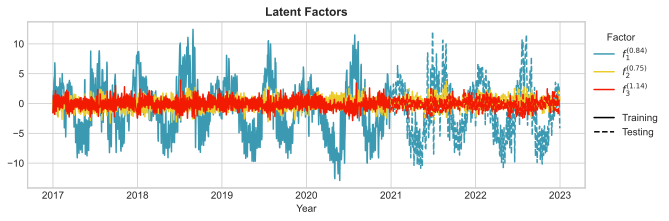

In [27]:
YeoJohnson      = PowerTransformer(method='yeo-johnson', standardize=False).fit(X=factors_train)

YJfactors_train = pd.DataFrame(
    YeoJohnson.transform(X=factors_train),
    columns     = ['PC1', 'PC2', 'PC3'],
    index       = data_train.index)

YJfactors_test  = pd.DataFrame(
    YeoJohnson.transform(X=factors_test),
    columns     = ['PC1', 'PC2', 'PC3'],
    index       = data_test.index)

lambdas         = YeoJohnson.lambdas_



fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(YJfactors_train.PC1, c=fancy[0], label='$f_1^{(%.2f)}$' % lambdas[0])
ax.plot(YJfactors_train.PC2, c=fancy[2], label='$f_2^{(%.2f)}$' % lambdas[1])
ax.plot(YJfactors_train.PC3, c=fancy[4], label='$f_3^{(%.2f)}$' % lambdas[2])

ax.plot(YJfactors_test.PC1, c=fancy[0], linestyle='--')
ax.plot(YJfactors_test.PC2, c=fancy[2], linestyle='--')
ax.plot(YJfactors_test.PC3, c=fancy[4], linestyle='--')

ax.set_xlabel('Year')
ax.set_title('Latent Factors', fontweight='bold')
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5), title='Factor')

ax2 = ax.twinx()
ax2.plot(np.NaN, np.NaN, linestyle='-', label='Training', c='k')
ax2.plot(np.NaN, np.NaN, linestyle='--', label='Testing', c='k')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

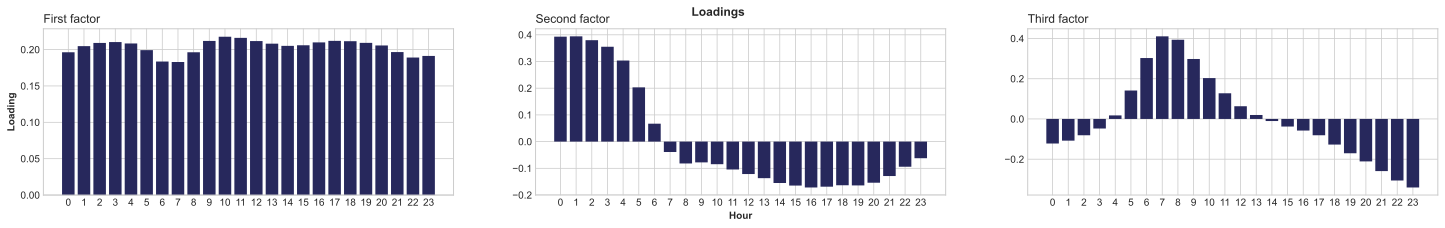

In [28]:
loadings = pd.DataFrame(
    model["FactorModel"].components_.T,
    columns = ['PC1', 'PC2', 'PC3']
)

loadings['var'] = [str(x) for x in range(0,24)]


fig, axes = plt.subplots(1, 3, figsize=(25, 3))
axes[0].bar(loadings['var'], loadings['PC1'], color = uc3m)
axes[0].set_title('First factor', loc='left')
axes[0].set_ylabel('Loading', fontweight='bold')
axes[1].bar(loadings['var'], loadings['PC2'], color = uc3m)
axes[1].set_title('Second factor', loc='left')
axes[1].set_xlabel('Hour', fontweight='bold')
axes[2].bar(loadings['var'], loadings['PC3'], color = uc3m)
axes[2].set_title('Third factor', loc='left')

fig.suptitle('Loadings', fontweight='bold')
plt.show()

## Reconstructing the Test Set 

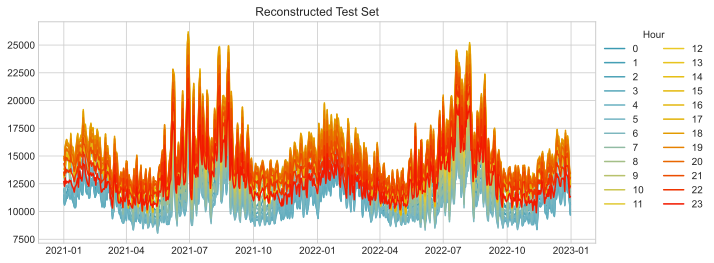

MAPE     = 0.021018121646327593 
MDAPE    = 0.018794361015308878
Accuracy = 0.40273972602739727
MAE      = 1.1191780821917807


In [29]:
PredF = YJfactors_test # this is the forecasting scaled with YJ

PredY = np.zeros_like(YScaleTest)
k     = 24

for i in range(k): # Regression model part
    PredY[:, i] = model["LinearModels"][i].predict(X=XScaleTest[:, i].reshape(-1, 1))   

OriginalScaleFactors  = YeoJohnson.inverse_transform(X=PredF)
PredY                += model["FactorModel"].inverse_transform(X=OriginalScaleFactors)
PredY                 = model["Scaler"][0].inverse_transform(X=PredY)
PredY                 = pd.DataFrame(PredY, 
                                     index = data_test.index, 
                                     columns = data_test.iloc[:, 0:24].columns)


fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
ax.set_title("Reconstructed Test Set")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

## Estimating the ARIMA models

## Forecasting

In [30]:
YJfactors = pd.concat([YJfactors_train, YJfactors_test])

forecaster_arimaf1 = ForecasterSarimax(regressor = ARIMA(order=(2,1,2), seasonal_order = (1,0,1,7), 
                                                         suppress_warnings=True))
forecaster_arimaf2 = ForecasterSarimax(regressor = ARIMA(order=(3,1,1), seasonal_order = (2,0,2,7), 
                                                         suppress_warnings=True))
forecaster_arimaf3 = ForecasterSarimax(regressor = ARIMA(order=(1,1,1), seasonal_order = (1,0,1,7), 
                                                         suppress_warnings=True))

### Scenario 1

In [31]:
metrica, f1s1 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf1,
                            y                  = YJfactors.PC1,
                            initial_train_size = len(YJfactors_train),
                            steps              = 30,
                            metric             = 'mean_absolute_error',
                            refit              = True,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f2s1 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf2,
                            y                  = YJfactors.PC2,
                            initial_train_size = len(YJfactors_train),
                            steps              = 30,
                            metric             = 'mean_absolute_error',
                            refit              = True,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f3s1 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf3,
                            y                  = YJfactors.PC3,
                            initial_train_size = len(YJfactors_train),
                            steps              = 30,
                            metric             = 'mean_absolute_error',
                            refit              = True,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

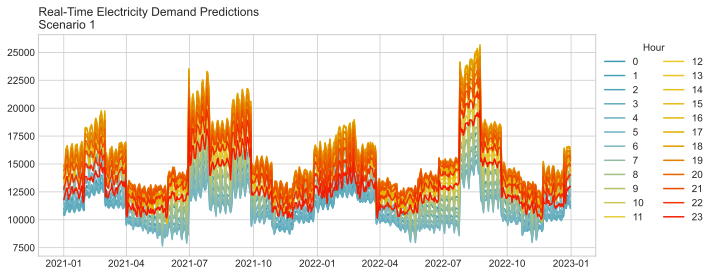

MAPE     = 0.11125533921608881 
MDAPE    = 0.10726787689864864
Accuracy = 0.2958904109589041
MAE      = 1.4356164383561645


In [32]:
PredF = pd.DataFrame({  # this is the forecasting scaled with YJ
    "PC1": f1s1["pred"],
    "PC2": f2s1["pred"],
    "PC3": f3s1["pred"]},
    index   = data_test.index)

PredY = np.zeros_like(YScaleTest)
k     = 24

for i in range(k): # Regression model part
    PredY[:, i] = model["LinearModels"][i].predict(X=XScaleTest[:, i].reshape(-1, 1))   

OriginalScaleFactors  = YeoJohnson.inverse_transform(X=PredF)
PredY                += model["FactorModel"].inverse_transform(X=OriginalScaleFactors)
PredY                 = model["Scaler"][0].inverse_transform(X=PredY)
PredY                 = pd.DataFrame(PredY, 
                                     index = data_test.index, 
                                     columns = data_test.iloc[:, 0:24].columns)


fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
ax.set_title("Real-Time Electricity Demand Predictions \nScenario 1", loc="left")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

### Scenario 2

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

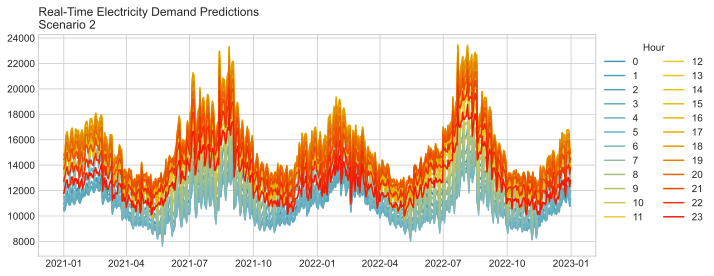

MAPE     = 0.07711418957183482 
MDAPE    = 0.07337689152420986
Accuracy = 0.37945205479452054
MAE      = 1.2575342465753425


In [33]:
metrica, f1s2 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf1,
                            y                  = YJfactors.PC1,
                            initial_train_size = len(YJfactors_train),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f2s2 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf2,
                            y                  = YJfactors.PC2,
                            initial_train_size = len(YJfactors_train),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f3s2 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf3,
                            y                  = YJfactors.PC3,
                            initial_train_size = len(YJfactors_train),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)


PredF = pd.DataFrame({  # this is the forecasting scaled with YJ
    "PC1": f1s2["pred"],
    "PC2": f2s2["pred"],
    "PC3": f3s2["pred"]},
    index   = data_test.index)

PredY = np.zeros_like(YScaleTest)
k     = 24

for i in range(k): # Regression model part
    PredY[:, i] = model["LinearModels"][i].predict(X=XScaleTest[:, i].reshape(-1, 1))   

OriginalScaleFactors  = YeoJohnson.inverse_transform(X=PredF)
PredY                += model["FactorModel"].inverse_transform(X=OriginalScaleFactors)
PredY                 = model["Scaler"][0].inverse_transform(X=PredY)
PredY                 = pd.DataFrame(PredY, 
                                     index = data_test.index, 
                                     columns = data_test.iloc[:, 0:24].columns)

fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
ax.set_title("Real-Time Electricity Demand Predictions \nScenario 2", loc="left")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

### Scenario 3

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

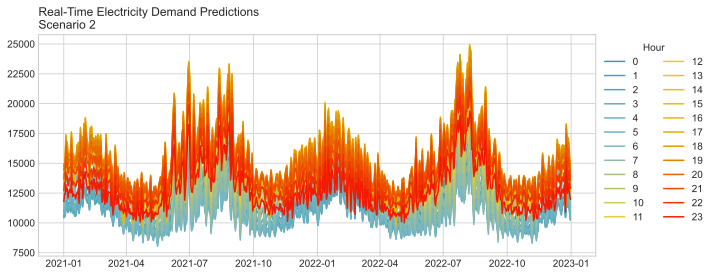

MAPE     = 0.055719607772926096 
MDAPE    = 0.051089078166042974
Accuracy = 0.3972602739726027
MAE      = 1.1424657534246576


In [34]:
metrica, f1s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf1,
                            y                  = YJfactors.PC1,
                            initial_train_size = len(YJfactors_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f2s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf2,
                            y                  = YJfactors.PC2,
                            initial_train_size = len(YJfactors_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f3s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf3,
                            y                  = YJfactors.PC3,
                            initial_train_size = len(YJfactors_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

PredF = pd.DataFrame({  # this is the forecasting scaled with YJ
    "PC1": f1s3["pred"],
    "PC2": f2s3["pred"],
    "PC3": f3s3["pred"]},
    index   = data_test.index)


PredY = np.zeros_like(YScaleTest)
k     = 24

for i in range(k): # Regression model part
    PredY[:, i] = model["LinearModels"][i].predict(X=XScaleTest[:, i].reshape(-1, 1))   

OriginalScaleFactors  = YeoJohnson.inverse_transform(X=PredF)
PredY                += model["FactorModel"].inverse_transform(X=OriginalScaleFactors)
PredY                 = model["Scaler"][0].inverse_transform(X=PredY)
PredY                 = pd.DataFrame(PredY, 
                                     index = data_test.index, 
                                     columns = data_test.iloc[:, 0:24].columns)

fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
ax.set_title("Real-Time Electricity Demand Predictions \nScenario 2", loc="left")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)

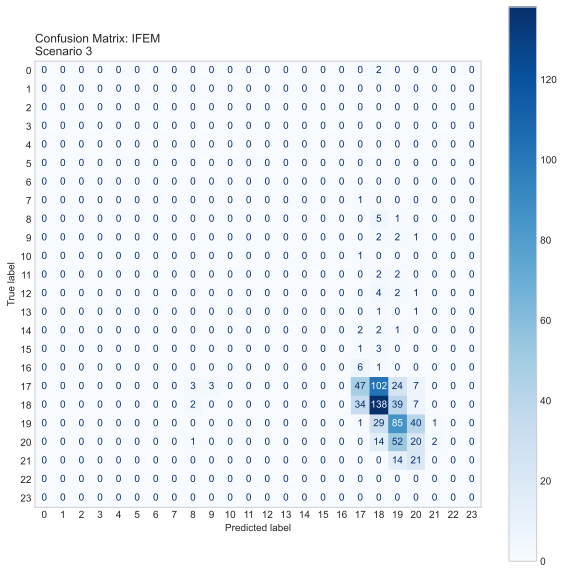

In [35]:
Y = data_test.iloc[:, 0:24]
Peak = Y.apply(np.argmax, axis=1)
PredPeak = PredY.apply(np.argmax, axis=1)
m = confusion_matrix(Peak, PredPeak, labels=[i for i in range(24)])
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Blues  # Change color map here
disp = ConfusionMatrixDisplay(confusion_matrix=m, display_labels=[i for i in range(24)])
disp.plot(ax=ax, cmap=cmap)
ax.grid(False)
ax.set_title("Confusion Matrix: IFEM \nScenario 3", loc="left")
plt.show()

# Weekend indicator

After the results of the previous section, we will propose some ideas aimed at improving the accuracy. The issue of the non-linear relationship between the independent and dependent variables can be addressed by performing a polynomial regression allowing each regressor to be $\pmb x_{i,t} = (1, x_{i,t}, x_{i,t}^2, \dots, x_{i,t}^{p-1})'$ for a certain value of $p$, where $x_{i,t}$ is the dry-bulb temperature at hour $i$ and day $t$. Nonetheless, incorporating the polynomial regression for different values of maximum degree, $p$, has led to over-fitting of the model, resulting in even worse results.

Furthermore, the consumption arise hour on weekends is delayed compared to weekdays. Therefore, it would also be a good idea to introduce a binary variable to indicate whether a day is a weekday or not. However, the predictions remain poor even after solely introducing the binary variable or combining it with the simple and polynomial regression of the dry-bulb temperature.

In [36]:
from sklearn.compose import ColumnTransformer

def WeekendIFEM(X, Y, polydeg, Nfactors, tol=1e-5, Maxit=100):
    YScaler = StandardScaler().fit(X=Y)
    XScaler = StandardScaler().fit(X=X)
    weekday = np.where(X.index.weekday > 4, 1, 0).reshape(-1, 1)

    AY            = YScaler.transform(X=Y)    # Multivariate time series (k series and T instances)
    AX            = XScaler.transform(X=X)    # Regressors 
    T             = AY.shape[0] 
    k             = AY.shape[1]
    PredXB        = np.zeros((T, k))
    B             = np.zeros((k, polydeg+1))
    flag          = 0
    linear_models = []
    
    for j in range(k): # Estimate \beta^{(0)} and w_i = y_i - X_i \beta^{(0)}_i
        y = AY[:, j].copy()
        x = np.hstack((AX[:, j].reshape(-1, 1), weekday))
        
        covariates   = ColumnTransformer(
            transformers=[('polynomial', PolynomialFeatures(degree=polydeg, include_bias=False), [0])], 
            remainder='passthrough')

        lm           = Pipeline([('poly', covariates),
                                 ('linear', LinearRegression(fit_intercept=False))])        
        lm           = lm.fit(X=x, y=y)
        PredXB[:, j] = lm.predict(X=x)
        B[j, :]      = lm.named_steps["linear"].coef_
        linear_models.append(lm)
    
    # Estimate P^{(0)} and F^{(0)}
    pca     = PCA(n_components=Nfactors).fit(X=AY-PredXB)
    factors = pca.transform(X=AY-PredXB)
    PredFL  = pca.inverse_transform(X=factors)
    
    # Iterative process
    BOld      = B.copy()
    PredXBOld = PredXB.copy()
    
    for ITE in range(Maxit):
        linear_models = []
        # R             = np.zeros(k)
        print(f"Currently on iteration: {ITE}", end="\r")
        
        for j in range(k): # Estimate \beta^{(ITE)} given P^{(ITE-1)} and F^{(ITE-1)}
            y = AY[:, j].copy() - PredFL[:, j]
            x = np.hstack((AX[:, j].reshape(-1, 1), weekday))
        
            covariates   = ColumnTransformer(
                transformers=[('polynomial', PolynomialFeatures(degree=polydeg, include_bias=False), [0])], 
                remainder='passthrough')

            lm           = Pipeline([('poly', covariates),
                                 ('linear', LinearRegression(fit_intercept=False))])        
            lm           = lm.fit(X=x, y=y)
            PredXB[:, j] = lm.predict(X=x)
            B[j, :]      = lm.named_steps["linear"].coef_
            linear_models.append(lm)
        
        # Estimate P^{(ITE)} and F^{(ITE)} given \beta^{(ITE-1)}
        pca     = PCA(n_components=Nfactors).fit(X=AY-PredXBOld)
        factors = pca.transform(X=AY-PredXBOld)
        PredFL  = pca.inverse_transform(X=factors)
        
        if np.sum(np.abs(BOld - B)) <= tol:
            flag = 1
            print(f"Method converged after {ITE+1} iterations.")
            break

        BOld = B.copy()
        PredXBOld = PredXB.copy()
    
    if flag == 0:
        print("Max. number of iterarions reached.")
    
    model = {"beta": B, "LinearModels": linear_models,
             "F": factors, "P": pca.components_, 
             "FactorModel": pca, "Scaler": [YScaler, XScaler]}
    
    return model

In [37]:
Y = data_train.iloc[:, 0:24]
X = data_train.iloc[:, 24:48]

model = WeekendIFEM(X=X, Y=Y, polydeg=2, Nfactors=3, tol=1e-5, Maxit=100)

Method converged after 2 iterations.


In [38]:
YScaleTest = model["Scaler"][0].transform(X=data_test.iloc[:, 0:24])
XScaleTest = model["Scaler"][1].transform(X=data_test.iloc[:, 24:48])

factors_train = pd.DataFrame(
    model["F"],
    columns = ['PC1', 'PC2', 'PC3'],
    index   = data_train.index)

weekday = np.where(data_test.index.weekday > 4, 1, 0).reshape(-1, 1)
PredY = np.zeros_like(YScaleTest)
k     = 24

for i in range(k): # Regression model part
    x = np.hstack((XScaleTest[:, i].reshape(-1, 1), weekday))
    PredY[:, i] = model["LinearModels"][i].predict(X=x)  

factors_test  = pd.DataFrame(
    model["FactorModel"].transform(X=YScaleTest-PredY), # Factor model of the regression errors
    columns = ['PC1', 'PC2', 'PC3'],
    index   = data_test.index)

In [39]:
YeoJohnson      = PowerTransformer(method='yeo-johnson', standardize=False).fit(X=factors_train)

YJfactors_train = pd.DataFrame(
    YeoJohnson.transform(X=factors_train),
    columns     = ['PC1', 'PC2', 'PC3'],
    index       = data_train.index)

YJfactors_test  = pd.DataFrame(
    YeoJohnson.transform(X=factors_test),
    columns     = ['PC1', 'PC2', 'PC3'],
    index       = data_test.index)

lambdas         = YeoJohnson.lambdas_

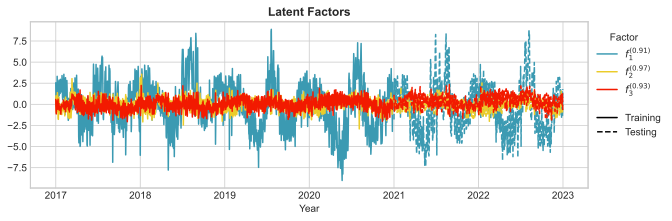

In [40]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(YJfactors_train.PC1, c=fancy[0], label='$f_1^{(%.2f)}$' % lambdas[0])
ax.plot(YJfactors_train.PC2, c=fancy[2], label='$f_2^{(%.2f)}$' % lambdas[1])
ax.plot(YJfactors_train.PC3, c=fancy[4], label='$f_3^{(%.2f)}$' % lambdas[2])

ax.plot(YJfactors_test.PC1, c=fancy[0], linestyle='--')
ax.plot(YJfactors_test.PC2, c=fancy[2], linestyle='--')
ax.plot(YJfactors_test.PC3, c=fancy[4], linestyle='--')

ax.set_xlabel('Year')
ax.set_title('Latent Factors', fontweight='bold')
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5), title='Factor')

ax2 = ax.twinx()
ax2.plot(np.NaN, np.NaN, linestyle='-', label='Training', c='k')
ax2.plot(np.NaN, np.NaN, linestyle='--', label='Testing', c='k')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

In [41]:
YJfactors = pd.concat([YJfactors_train, YJfactors_test])

forecaster_arimaf1 = ForecasterSarimax(regressor = ARIMA(order=(2,1,3), seasonal_order = (1,0,1, 7),
                                                         with_intercept=False, suppress_warnings=True))
forecaster_arimaf2 = ForecasterSarimax(regressor = ARIMA(order=(0,1,1), seasonal_order = (0,0,1, 7),
                                                        with_intercept=False, suppress_warnings=True))
forecaster_arimaf3 = ForecasterSarimax(regressor = ARIMA(order=(1,1,1), seasonal_order = (2,0,2, 7), 
                                                         suppress_warnings=True))

metrica, f1s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf1,
                            y                  = YJfactors.PC1,
                            initial_train_size = len(YJfactors_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f2s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf2,
                            y                  = YJfactors.PC2,
                            initial_train_size = len(YJfactors_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

metrica, f3s3 = backtesting_sarimax(
                            forecaster         = forecaster_arimaf3,
                            y                  = YJfactors.PC3,
                            initial_train_size = len(YJfactors_train),
                            steps              = 1,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = False,
                            show_progress      = True)

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

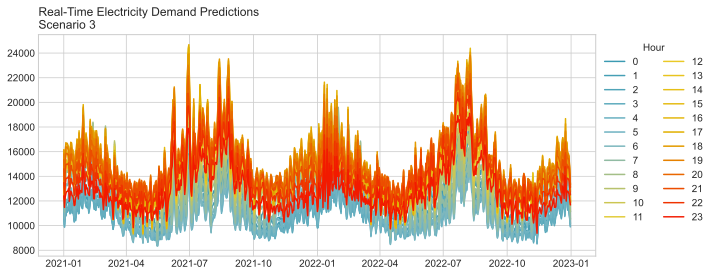

MAPE     = 0.04325814456724099 
MDAPE    = 0.03909415327822948
Accuracy = 0.410958904109589
MAE      = 1.2273972602739727


In [44]:
PredF = pd.DataFrame({  # this is the forecasting scaled with YJ
    "PC1": f1s3["pred"],
    "PC2": f2s3["pred"],
    "PC3": f3s3["pred"]},
    index   = data_test.index)

PredY = np.zeros_like(YScaleTest)
k     = 24

for i in range(k): # Regression model part
    x = np.hstack((XScaleTest[:, i].reshape(-1, 1), weekday))
    PredY[:, i] = model["LinearModels"][i].predict(X=x)      

OriginalScaleFactors  = YeoJohnson.inverse_transform(X=PredF)
PredY                += model["FactorModel"].inverse_transform(X=OriginalScaleFactors)
PredY                 = model["Scaler"][0].inverse_transform(X=PredY)
PredY                 = pd.DataFrame(PredY, 
                                     index = data_test.index, 
                                     columns = data_test.iloc[:, 0:24].columns)

# Plot
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(24):
    ax.plot(PredY.iloc[:,i], color = fancy24[i], label=i)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title="Hour")
ax.set_title("Real-Time Electricity Demand Predictions \nScenario 3", loc="left")
plt.show()

metrics = mape(data_test.iloc[:, 0:24], PredY)
summary = f"MAPE     = {metrics['MAPE']} \nMDAPE    = {metrics['MDAPE']}\n" \
          f"Accuracy = {accuracy(data_test.iloc[:, 0:24], PredY)}\n" \
          f"MAE      = {mae(data_test.iloc[:, 0:24], PredY)}"
print(summary)